# Klasyfikacja mieszkań

# Analiza danych

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
data = pd.read_csv('train_data.csv')

### Analiza wstępna

In [ ]:
# data.info()
# data.describe()
data.head()
# data.isnull().sum()

# plt.hist(data['SalePrice'])
# plt.title("Sale Price")
# plt.show()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


### Etykietowanie

In [2]:
data["Class"] = 0
data.loc[(data['SalePrice'] > 100000) & (data['SalePrice'] <= 350000), "Class"] = 1
data.loc[data["SalePrice"] > 350000, "Class"] = 2
data['Class'].value_counts()
data.drop('SalePrice', axis=1, inplace=True)

### Obróbka danych dyskretnych

In [3]:
no_numeric_data = ["HallwayType", "HeatingType", "AptManageType", "SubwayStation"]
no_numeric_order_data = ["TimeToBusStop", "TimeToSubway"]

# for column in no_numeric_data + no_numeric_order_data:
#   print(data[column].value_counts())

# sprawdzenie czy każde mieszkanie które nie ma obok przystanku nie ma też metra -> TAK
# len(data[data['TimeToSubway'] == 'no_bus_stop_nearby']) == \
# len(data[(data['TimeToSubway'] == 'no_bus_stop_nearby') & (data['SubwayStation'] == 'no_subway_nearby')])

unique_times = data['TimeToBusStop'].dropna().unique()
time_mapping = {
    '0~5min': 0,
    '5min~10min': 1,
    '10min~15min': 2,
    '15min~20min': 3,
}
data['TimeToBusStop'] = data['TimeToBusStop'].map(time_mapping)

mapping = {
    '0-5min': 0,
    '5min~10min': 1,
    '10min~15min': 2,
    '15min~20min': 3,
    'no_bus_stop_nearby': 4
}
data['TimeToSubway'] = data['TimeToSubway'].map(mapping)

print(data['TimeToBusStop'].value_counts(dropna=False))
print(data['TimeToSubway'].value_counts(dropna=False))

for column in no_numeric_data:
  dummies = pd.get_dummies(data[column], drop_first=True)
  dummies = dummies.astype(int)
  data = pd.concat([data, dummies], axis=1)
  data = data.drop(column, axis=1)

# data.head()
data.drop('no_subway_nearby', axis=1, inplace=True)
data.info()

TimeToBusStop
0    3148
1     938
2      38
Name: count, dtype: int64
TimeToSubway
0    1960
1     792
3     682
2     526
4     164
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4124 entries, 0 to 4123
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YearBuilt                  4124 non-null   int64  
 1   Size(sqf)                  4124 non-null   int64  
 2   Floor                      4124 non-null   int64  
 3   N_Parkinglot(Ground)       4124 non-null   float64
 4   N_Parkinglot(Basement)     4124 non-null   float64
 5   TimeToBusStop              4124 non-null   int64  
 6   TimeToSubway               4124 non-null   int64  
 7   N_manager                  4124 non-null   float64
 8   N_elevators                4124 non-null   float64
 9   N_FacilitiesInApt          4124 non-null   int64  
 10  N_FacilitiesNearBy(Total)  4124 non-null   float64
 11  N

### Korelacja danych

In [4]:
import seaborn as sns

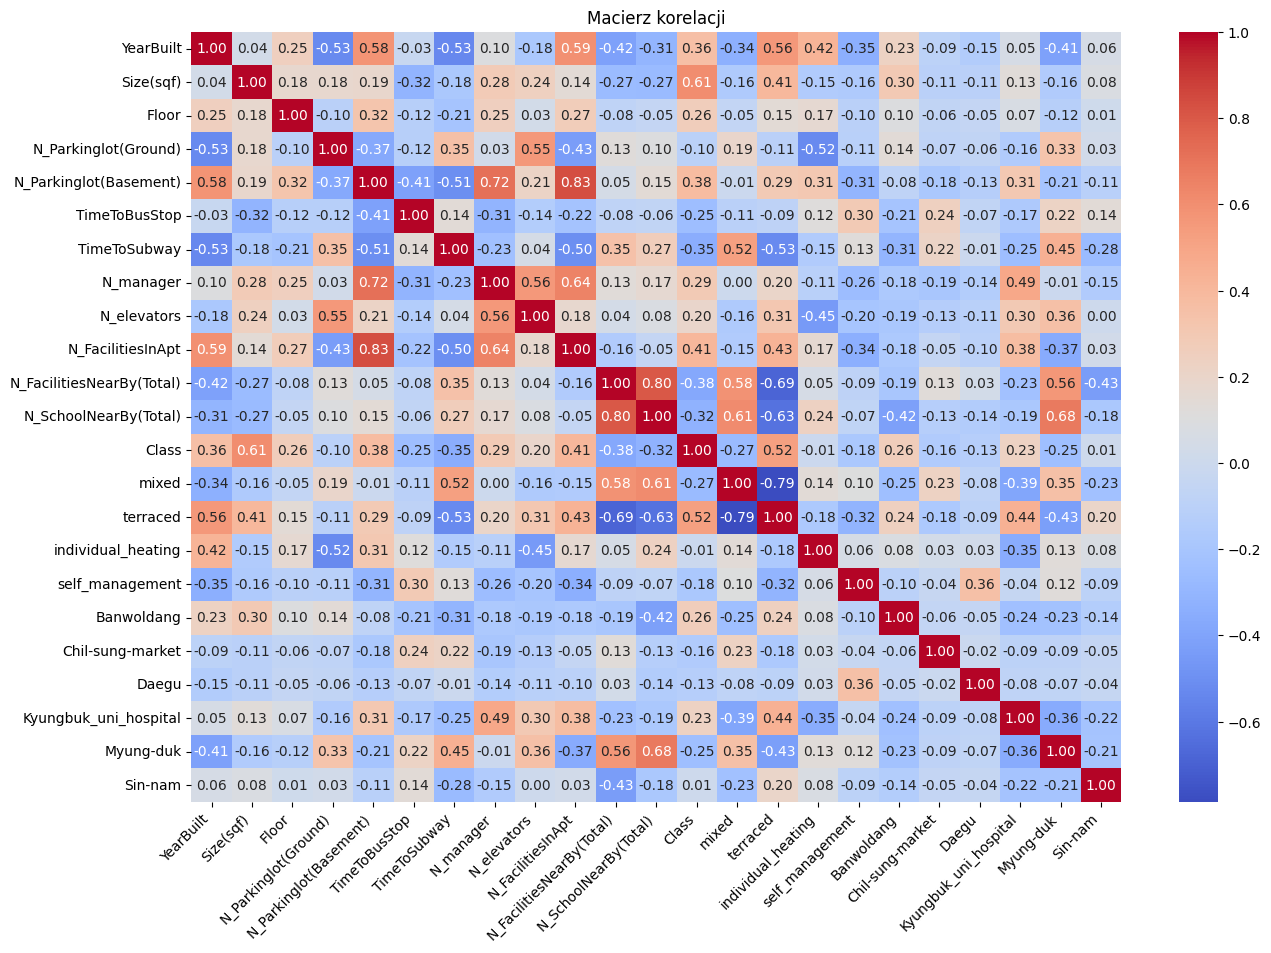

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(15, 10))  # Ustaw rozmiar wykresu
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Macierz korelacji')
plt.show()

In [5]:
# odrzcenie nisko skorelowanych danych - współczynnik korelacji w przedziale [-0.2; 0.2]
data.drop(['N_Parkinglot(Ground)', 'TimeToBusStop','N_elevators', 'individual_heating',
           'self_management', 'Chil-sung-market', 'Daegu', 'Sin-nam'], axis=1, inplace=True)

# Model

In [6]:
!nvidia-smi

Tue Mar 25 21:00:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## Balansowanie klas

In [8]:
!pip install imbalanced-learn

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
X = data.drop(columns=['Class'])
y = data['Class']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
data_resampled['Class'] = y_resampled

## Podział danych

In [11]:
train, valid = train_test_split(data_resampled, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(train.drop('Class', axis=1).values, dtype=torch.float),
                              torch.tensor(train['Class'].values, dtype=torch.float))
valid_dataset = TensorDataset(torch.tensor(valid.drop('Class', axis=1).values, dtype=torch.float),
                              torch.tensor(valid['Class'].values, dtype=torch.float))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

## Parametry modelu i procesu uczenia

In [12]:
PARAMS = {
    'lr': 0.001,
    'epochs': 2000,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'inputs': len(train_dataset[0][0]),
    'layers': [256, 128],
    'outputs': 3,
    'dropout_rate': 0.15
}

class_counts = torch.tensor(data['Class'].value_counts().sort_index())
print(class_counts)
class_counts[1] = class_counts[1] * 0.3
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(PARAMS['device'])
print(class_weights)

tensor([ 562, 2992,  570])
tensor([0.3828, 0.2398, 0.3774], device='cuda:0')


## Architektura Modelu

In [13]:
class ApartmentClassificator(nn.Module):
    def __init__(self, input_size, hid_layers, output_size):
        super(ApartmentClassificator, self).__init__()
        layers = []
        in_features = input_size

        for hidden_size in hid_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(PARAMS['dropout_rate']))
            in_features = hidden_size

        layers.append(nn.Linear(in_features, output_size))
        self.model = nn.Sequential(*layers)


    def forward(self, x):
        return self.model(x)

## Pętla uczenia

In [14]:
model = ApartmentClassificator(PARAMS['inputs'], PARAMS['layers'], PARAMS['outputs']).to(PARAMS['device'])
# def weighted_mse_loss(outputs, labels, weights):
#     classes = torch.where(labels <= 0.5, 0,
#                 torch.where(labels <= 1.5, 1, 2)).long()
#     sample_weights = weights[classes]
#     loss = (sample_weights * (outputs - labels).pow(2)).mean()
#     return loss

# loss_fn = nn.CrossEntropyLoss(weight=class_weights)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=PARAMS['lr'])

for epoch in range(PARAMS['epochs']):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(PARAMS['device']), labels.to(PARAMS['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        # outputs = outputs.squeeze(dim=1)
        loss = loss_fn(outputs, labels.long())
        # loss = weighted_mse_loss(outputs, labels, class_weights)
        loss.backward()
        optimizer.step()

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(PARAMS['device']), labels.to(PARAMS['device'])
            outputs = model(inputs)
            # outputs = outputs.squeeze(dim=1)
            # loss = nn.MSELoss()(outputs, labels)
            loss = loss_fn(outputs, labels.long())
            # loss = weighted_mse_loss(outputs, labels, class_weights)
            valid_loss += loss.item() * inputs.size(0)

    valid_loss /= len(valid_loader.dataset)

    if epoch % 20 == 0:
      print(f'Epoch [{epoch+1}/{PARAMS["epochs"]}], Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss:.4f}')

Epoch [1/2000], Train Loss: 0.6898, Valid Loss: 0.5192
Epoch [21/2000], Train Loss: 0.3252, Valid Loss: 0.3201
Epoch [41/2000], Train Loss: 0.3168, Valid Loss: 0.2751
Epoch [61/2000], Train Loss: 0.3552, Valid Loss: 0.2679
Epoch [81/2000], Train Loss: 0.3776, Valid Loss: 0.2615
Epoch [101/2000], Train Loss: 0.3567, Valid Loss: 0.2645
Epoch [121/2000], Train Loss: 0.3434, Valid Loss: 0.2524
Epoch [141/2000], Train Loss: 0.2348, Valid Loss: 0.2485
Epoch [161/2000], Train Loss: 0.3077, Valid Loss: 0.2458
Epoch [181/2000], Train Loss: 0.3130, Valid Loss: 0.2370
Epoch [201/2000], Train Loss: 0.3177, Valid Loss: 0.2555
Epoch [221/2000], Train Loss: 0.2576, Valid Loss: 0.2419
Epoch [241/2000], Train Loss: 0.2666, Valid Loss: 0.2402
Epoch [261/2000], Train Loss: 0.2172, Valid Loss: 0.2360
Epoch [281/2000], Train Loss: 0.2489, Valid Loss: 0.2410
Epoch [301/2000], Train Loss: 0.2142, Valid Loss: 0.2354
Epoch [321/2000], Train Loss: 0.2455, Valid Loss: 0.2456
Epoch [341/2000], Train Loss: 0.2368,

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Epoch [2000/2000], Train Loss: 0.2035, Valid Loss: 0.2304, Valid Accuracy: 0.9159


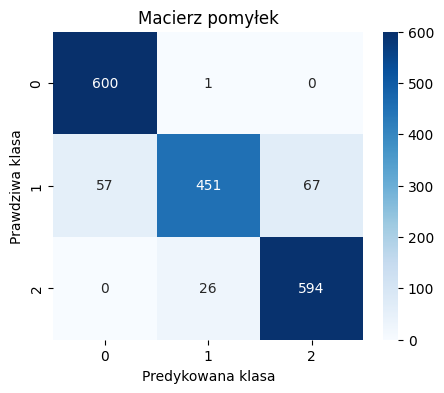

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       601
         1.0       0.94      0.78      0.86       575
         2.0       0.90      0.96      0.93       620

    accuracy                           0.92      1796
   macro avg       0.92      0.91      0.91      1796
weighted avg       0.92      0.92      0.91      1796



In [16]:
# Obliczenie accuracy
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(PARAMS['device']), labels.to(PARAMS['device'])
        outputs = model(inputs)
        # outputs = outputs.squeeze(dim=1)

        # Konwersja na klasy
        _, predicted_classes = torch.max(outputs, 1)
        # predicted_classes = torch.zeros_like(outputs, dtype=torch.int64)  # Inicjalizacja tablicy z klasami
        # predicted_classes[outputs <= 0.5] = 0  # Klasa 'cheap'
        # predicted_classes[(outputs > 0.5) & (outputs <= 1.5)] = 1  # Klasa 'average'
        # predicted_classes[outputs > 1.5] = 2  # Klasa 'expensive'

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_classes.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions)

# Wyświetlenie accuracy
print(f'Epoch [{epoch+1}/{PARAMS["epochs"]}], Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {accuracy:.4f}')

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.show()

print(classification_rep)

## Predykcje modelu

### Import i preprocessing danych

In [17]:
test = pd.read_csv('test_data.csv')

no_numeric_data = ["HallwayType", "HeatingType", "AptManageType", "SubwayStation"]
no_numeric_order_data = ["TimeToBusStop", "TimeToSubway"]

unique_times = test['TimeToBusStop'].dropna().unique()
time_mapping = {
    '0~5min': 0,
    '5min~10min': 1,
    '10min~15min': 2,
    '15min~20min': 3,
}
test['TimeToBusStop'] = test['TimeToBusStop'].map(time_mapping)

mapping = {
    '0-5min': 0,
    '5min~10min': 1,
    '10min~15min': 2,
    '15min~20min': 3,
    'no_bus_stop_nearby': 4
}
test['TimeToSubway'] = test['TimeToSubway'].map(mapping)

for column in no_numeric_data:
  dummies = pd.get_dummies(test[column], drop_first=True)
  dummies = dummies.astype(int)
  test = pd.concat([test, dummies], axis=1)
  test = test.drop(column, axis=1)

test.drop('no_subway_nearby', axis=1, inplace=True)
test.drop(['N_Parkinglot(Ground)', 'TimeToBusStop','N_elevators', 'individual_heating',
           'self_management', 'Chil-sung-market', 'Daegu', 'Sin-nam'], axis=1, inplace=True)

In [18]:
test.columns

Index(['YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Basement)',
       'TimeToSubway', 'N_manager', 'N_FacilitiesInApt',
       'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)', 'mixed',
       'terraced', 'Banwoldang', 'Kyungbuk_uni_hospital', 'Myung-duk'],
      dtype='object')

### Wykonanie predykcji

In [19]:
import numpy as np

In [20]:
test_dataset = TensorDataset(torch.tensor(test.values, dtype=torch.float))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()

all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(PARAMS['device'])
        outputs = model(inputs)
        _, predicted_classes = torch.max(outputs, 1)
        all_predictions.extend(predicted_classes.cpu().numpy())


predicted_classes = np.array(all_predictions)
# all_predictions = np.concatenate(all_predictions)

# predicted_classes = np.zeros_like(all_predictions, dtype=object)
# predicted_classes[all_predictions <= 0.5] = 0
# predicted_classes[(all_predictions > 0.5) & (all_predictions <= 1.5)] = 1
# predicted_classes[all_predictions > 1.5] = 2

In [21]:
pd.DataFrame({'Class': predicted_classes}).to_csv('pred.csv', index=False, header=False)